In [1]:
!kaggle competitions download -c kuzushiji-recognition -p raw

!unzip -n -q raw/train.csv.zip -d data
!chmod 444 data/train.csv 
!unzip -n -q raw/train_images.zip -d data/train_images
!unzip -n -q raw/test_images.zip -d data/test_images

!cp -f raw/unicode_translation.csv data/

unicode_translation.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_images.zip: Skipping, found more recently modified local copy (use --force to force download)
train_images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!pip install wget
!wget -nd -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip -P raw
!unzip -n -q raw/NotoSansCJKjp-hinted.zip -d assets

NotoSansCJKjp-hinte 100%[===================>] 115.49M  62.9MB/s    in 1.8s    


In [3]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import cv2

import re
import csv
from tqdm import tqdm_notebook as tqdm

In [4]:
input_dir = 'data'

font_path = 'assets/NotoSansCJKjp-Regular.otf'
prop = font_manager.FontProperties(fname=font_path)

In [5]:
df = pd.read_csv(input_dir + '/train.csv')
df['chars'] = df.labels.str.findall(r"[\w\+]{6}[\s\d]*\d")
df.head()

,image_id,labels,chars
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...,"[U+306F 1231 3465 133 53, U+304C 275 1652 84 6..."
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...,"[U+306F 1087 2018 103 65, U+304B 1456 1832 40 ..."
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...,"[U+306F 572 1376 125 57, U+306E 1551 2080 69 6..."
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...,"[U+3082 1455 3009 65 44, U+516B 1654 1528 141 ..."
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...,"[U+309D 1201 2949 27 33, U+309D 1196 1539 27 3..."


In [6]:
with open('data/unicode_translation.csv') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    unicode = dict(reader)

In [7]:
def id_to_path(input_id, dir_type='train'):
    path = input_dir + '/' + dir_type + '_images/' + input_id
    if '.jpg' not in path:
        path = path + '.jpg'
        
    return path

def label_explode(l):
    try:
        codename, x, y, w, h = str.split(l)
    except TypeError:
        print('skipping {}'.format(l))
        return None
    
    try:
        char = unicode[codename]
    except KeyError:
        try:
            char = unicode['U' + codename]
        except KeyError:
            print('{} not found in unicode lookup, skipping'.format(codename))
            return None
    
    x, y, w, h = int(x), int(y), int(w), int(h)
    
    return char, codename, x, y, w, h

def page_to_bw(*args, **kwargs):
    path = id_to_path(*args, **kwargs)    
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    (thresh, img_bw) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bw = cv2.bitwise_not(img_bw)
    
    return img_bw

def print_labels(ax, labels, im_id):
    img_bw = page_to_bw(im_id)
    ax.imshow(img_bw, cmap='gray')
    
    for l in labels:
        char, uc, x, y, w, h = label_explode(l)
        rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)

        x_text = x + w + 10
        y_text = y + (h/2)
        ax.text(x_text, y_text, char, fontproperties=prop, color='r', size=24)
    
    return img_bw

def find_label(l, img):
    char, uc, x, y, w, h = label_explode(l)
    limg = img[y:y+h, x:x+w]
    
    return limg

def make_square(img, dim=(64, 64)):
    aspect = img.shape
    max_aspect = max(aspect)
    
    if max_aspect % 2 != 0:
        max_aspect += 11
    else:
        max_aspect += 10
        
    y_growth = (max_aspect - aspect[0])/2
    x_growth = max_aspect - aspect[1]
    
    t, b, l, r = int(np.floor(y_growth/2)), int(np.ceil(y_growth/2)), int(np.floor(x_growth/2)), int(np.ceil(x_growth/2))
    
    square_img = cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=(0,0,0))
    square_img = cv2.resize(square_img, dim)
    
    return square_img

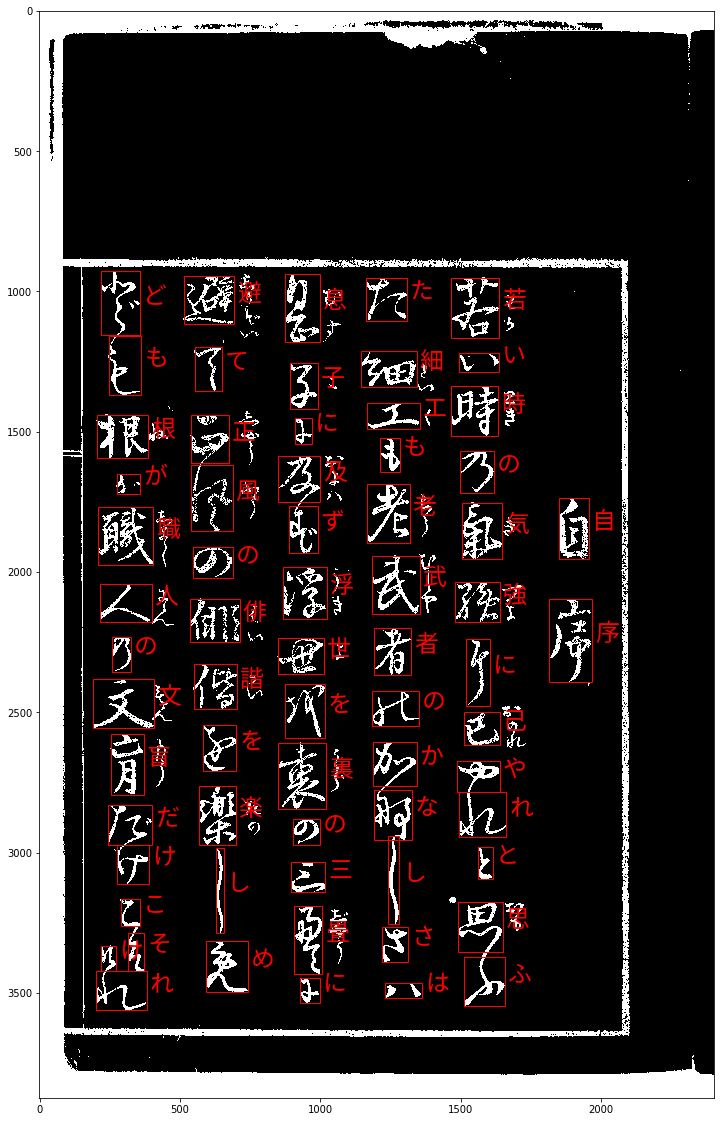

In [8]:
row = df.loc[df.image_id == '100241706_00004_2']
test_id = row['image_id'].values[0]
test_labels = row['chars'].values[0]

fig, ax = plt.subplots(figsize=(20,20))
img_bw = print_labels(ax, test_labels, test_id)

In [9]:
df1 = df[['image_id','chars']].explode('chars').reset_index()
df2 = pd.DataFrame(df1['chars'].str.split(expand=True).values, columns=('unicode', 'x_min', 'y_min', 'width', 'height'))

dfo = pd.concat([df1,df2], axis=1)
nums = ['x_min','y_min','width','height']
for n in nums:
    dfo[n] = pd.to_numeric(dfo[n], errors='coerce', downcast='integer')

dfo['x_max'] = dfo.x_min + dfo.width
dfo['y_max'] = dfo.y_min + dfo.height

dfo = dfo.drop(['index'], axis=1).dropna()

In [10]:
grouped = dfo.groupby('image_id')
out = []
for name, dfg in tqdm(grouped):
    source_img = page_to_bw(name)
    dfg['img'] = dfg.apply(lambda row: make_square(find_label(row.chars, source_img)), axis=1)
    out.append(dfg)
    
dfo = pd.concat(out)

/Users/nicholasmi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


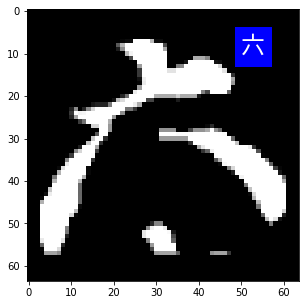

In [11]:
row = dfo.loc[89237, :]
box_props = props = dict(boxstyle='square', facecolor='blue', alpha=1)

fig = plt.figure(figsize=(5,5))
plt.imshow(row['img'], cmap='gray')
plt.text(50, 10, unicode[row['unicode']], fontproperties=prop, color='w', size=24, bbox=box_props)
plt.show()

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

In [13]:
dfo.groupby('unicode')['img'].count().sort_values(ascending=False).iloc[:5]

unicode
U+306B    24685
U+306E    24136
U+3057    22209
U+3066    20569
U+3068    16588
Name: img, dtype: int64

In [67]:
freq = dfo.groupby('unicode')['img'].count().sort_values(ascending=False).iloc[:10].index.to_list()
keras_test = dfo.loc[dfo.unicode.isin(freq), :]

arr = keras_test.img.to_numpy()
X = np.concatenate(arr).ravel().reshape((-1,64,64,1))

le = LabelEncoder()
y = le.fit_transform(keras_test.unicode)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8228110)

In [68]:
model = Sequential([Flatten(input_shape=(64,64,1)),
                    Dense(64, activation='sigmoid'),
                    Dense(10, activation='softmax'),
                    Dense(50, activation='relu'),
                    Dense(10,  activation='softmax')])
model.compile(optimizer = 'adam',loss='sparse_categorical_crossentropy',metrics =['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=1000)
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/5
144772/144772 [==============================] - 4s 28us/step - loss: 1.8688 - acc: 0.5232
Epoch 2/5
144772/144772 [==============================] - 3s 22us/step - loss: 1.0999 - acc: 0.6667
Epoch 3/5
144772/144772 [==============================] - 3s 22us/step - loss: 0.9165 - acc: 0.7147
Epoch 4/5
144772/144772 [==============================] - 3s 22us/step - loss: 0.8353 - acc: 0.7318
Epoch 5/5
36193/36193 [==============================] - 1s 38us/step
Accuracy: 77.53


In [69]:
for i in freq:
    print(i, unicode[i])

U+306B に
U+306E の
U+3057 し
U+3066 て
U+3068 と
U+3092 を
U+306F は
U+304B か
U+308A り
U+306A な


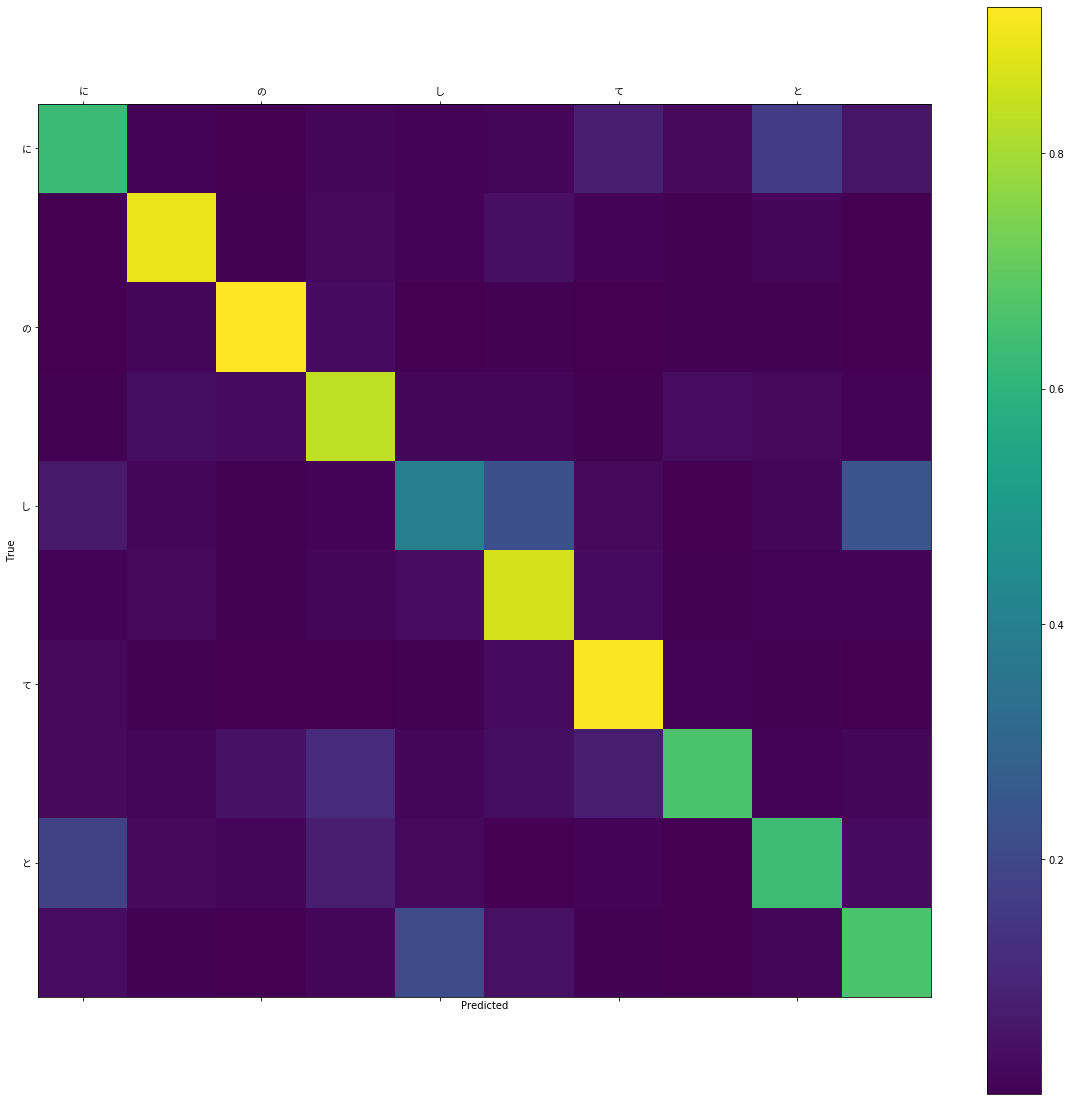

In [72]:
labels = np.unique(y_test)
kanji = [unicode[f] for f in freq]
cm = confusion_matrix(y_test, [np.argmax(pred) for pred in list(model.predict(X_test))], labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + kanji, fontproperties=prop)
ax.set_yticklabels([''] + kanji, fontproperties=prop)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()